In [72]:
import firebase_admin
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from firebase_admin import credentials, firestore
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import math

# Firebase Initialization
cred = credentials.Certificate("adminkey.json")
#firebase_admin.initialize_app(cred)
db = firestore.client()

# Constants
INCLUDE_ONLY = ['Stephen', 'Lillian', 'Ren', 'Yuanheng', 'Ethan Shao', 'z']
ACTIVITIES = ['sit', 'walk', 'upstair', 'downstair']
TIME_START, TIME_END = 500, 6000  
SAMPLING_RATE = 100  # Hz
OVERLAP = 0.5  # 50% overlap

# Sequence length in seconds for chunking (experiment with values)
CHUNK_SIZE = 1

# Transformer hyperparams
BATCH_SIZE = 64
EPOCHS = 100
LEARNING_RATE = 0.001
EMB_SIZE = 128
NHEAD = 8
NHID = 128
NLAYERS = 3
DROPOUT = 0.1

In [73]:
def fetch_data(collection_name):
    """Fetch raw accelerometer data filtered by time and included people."""
    data_raw, docs = [], []
    for person in db.collection(collection_name).stream():
        person_name = str(person.to_dict().get('name', ''))
        if person_name not in INCLUDE_ONLY:
            continue

        for activity in ACTIVITIES:
            for recording in db.collection(collection_name).document(person_name).collection(activity).stream():
                record = recording.to_dict()
                if 'acceleration' not in record:
                    continue

                df = pd.DataFrame(record['acceleration'])
                if 'time' in df.columns:
                    df = df[(df['time'] >= TIME_START) & (df['time'] <= TIME_END)].drop(columns=['time'])
                    data_raw.append(df)
                    docs.append({'activity': activity})
    return data_raw, docs

In [74]:
def chunk_data_raw(data_raw, docs, chunk_size_sec, sampling_rate, overlap=OVERLAP):
    """Chunk raw acceleration data into overlapping windows with labels."""
    data, labels = [], []
    chunk_samples = int(chunk_size_sec * sampling_rate)
    step = int(chunk_samples * (1 - overlap))

    for i, df in enumerate(data_raw):
        for start in range(0, len(df) - chunk_samples + 1, step):
            chunk = df.iloc[start:start + chunk_samples]
            if len(chunk) == chunk_samples:
                data.append(chunk[['x', 'y', 'z']].values)  # raw accel values, no features
                labels.append(ACTIVITIES.index(docs[i]['activity']))
    return np.array(data), np.array(labels)

In [75]:
class PositionalEncoding(nn.Module):
    def __init__(self, emb_size, dropout=0.1, maxlen=5000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

        pe = torch.zeros(maxlen, emb_size)
        position = torch.arange(0, maxlen, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, emb_size, 2).float() * (-math.log(10000.0) / emb_size))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # shape (1, maxlen, emb_size)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x shape: (batch, seq_len, emb_size)
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

In [76]:
class TransformerClassifier(nn.Module):
    def __init__(self, emb_size=EMB_SIZE, nhead=NHEAD, nhid=NHID, nlayers=NLAYERS, nclasses=len(ACTIVITIES), dropout=DROPOUT):
        super().__init__()
        self.embedding = nn.Linear(3, emb_size)  # x,y,z -> emb_size
        self.pos_encoder = PositionalEncoding(emb_size, dropout)
        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_size, nhead=nhead, dim_feedforward=nhid, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=nlayers)
        self.classifier = nn.Linear(emb_size, nclasses)
        self.emb_size = emb_size

    def forward(self, x):
        # x shape: (batch, seq_len, 3)
        x = self.embedding(x) * math.sqrt(self.emb_size)  # (batch, seq_len, emb_size)
        x = self.pos_encoder(x)
        x = x.permute(1, 0, 2)  # (seq_len, batch, emb_size)
        x = self.transformer_encoder(x)
        x = x.mean(dim=0)  # average pooling over sequence dimension -> (batch, emb_size)
        x = self.classifier(x)
        return x

In [77]:
def train_and_evaluate():
    # Fetch and chunk data from Firestore
    print("Fetching training data...")
    training_data_raw, training_docs = fetch_data("training")
    print(f"Fetched {len(training_data_raw)} training raw data entries.")
    print("Fetching testing data...")
    testing_data_raw, testing_docs = fetch_data("testing")
    print(f"Fetched {len(testing_data_raw)} testing raw data entries.")

    X_train, y_train = chunk_data_raw(training_data_raw, training_docs, CHUNK_SIZE, SAMPLING_RATE, OVERLAP)
    X_test, y_test = chunk_data_raw(testing_data_raw, testing_docs, CHUNK_SIZE, SAMPLING_RATE, OVERLAP)

    print(f"Training chunks: {X_train.shape}, Training labels: {y_train.shape}")
    print(f"Testing chunks: {X_test.shape}, Testing labels: {y_test.shape}")

    # Convert to torch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.long)

    # Dataset and DataLoader
    train_ds = TensorDataset(X_train, y_train)
    test_ds = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    model = TransformerClassifier().to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {avg_loss:.4f}")

    # Evaluation
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            predicted = preds.argmax(dim=1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=ACTIVITIES))

    # Confusion matrix with seaborn heatmap
    cm = confusion_matrix(all_labels, all_preds)
    correct_counts = np.diag(cm)
    total_per_class = cm.sum(axis=1)
    accuracy_per_class = (correct_counts / total_per_class) * 100
    yticklabels_with_acc = [f"{act} ({accuracy_per_class[i]:.1f}%)" for i, act in enumerate(ACTIVITIES)]

    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", xticklabels=ACTIVITIES, yticklabels=yticklabels_with_acc)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Transformer Model Confusion Matrix")
    plt.show()

Fetching training data...
Fetched 48 training raw data entries.
Fetching testing data...
Fetched 48 testing raw data entries.
Training chunks: (480, 100, 3), Training labels: (480,)
Testing chunks: (480, 100, 3), Testing labels: (480,)
Using device: cpu


C:\Users\wenzh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/100, Loss: 1.1796
Epoch 2/100, Loss: 0.8899
Epoch 3/100, Loss: 0.7343
Epoch 4/100, Loss: 0.6389
Epoch 5/100, Loss: 0.5535
Epoch 6/100, Loss: 0.5171
Epoch 7/100, Loss: 0.4451
Epoch 8/100, Loss: 0.4218
Epoch 9/100, Loss: 0.3838
Epoch 10/100, Loss: 0.3998
Epoch 11/100, Loss: 0.3795
Epoch 12/100, Loss: 0.3461
Epoch 13/100, Loss: 0.3495
Epoch 14/100, Loss: 0.2928
Epoch 15/100, Loss: 0.2616
Epoch 16/100, Loss: 0.2456
Epoch 17/100, Loss: 0.2571
Epoch 18/100, Loss: 0.2235
Epoch 19/100, Loss: 0.2740
Epoch 20/100, Loss: 0.2004
Epoch 21/100, Loss: 0.2182
Epoch 22/100, Loss: 0.2240
Epoch 23/100, Loss: 0.2115
Epoch 24/100, Loss: 0.2066
Epoch 25/100, Loss: 0.2007
Epoch 26/100, Loss: 0.2182
Epoch 27/100, Loss: 0.1871
Epoch 28/100, Loss: 0.1590
Epoch 29/100, Loss: 0.1730
Epoch 30/100, Loss: 0.2129
Epoch 31/100, Loss: 0.2324
Epoch 32/100, Loss: 0.1674
Epoch 33/100, Loss: 0.1734
Epoch 34/100, Loss: 0.1287
Epoch 35/100, Loss: 0.1792
Epoch 36/100, Loss: 0.1556
Epoch 37/100, Loss: 0.1613
Epoch 38/1

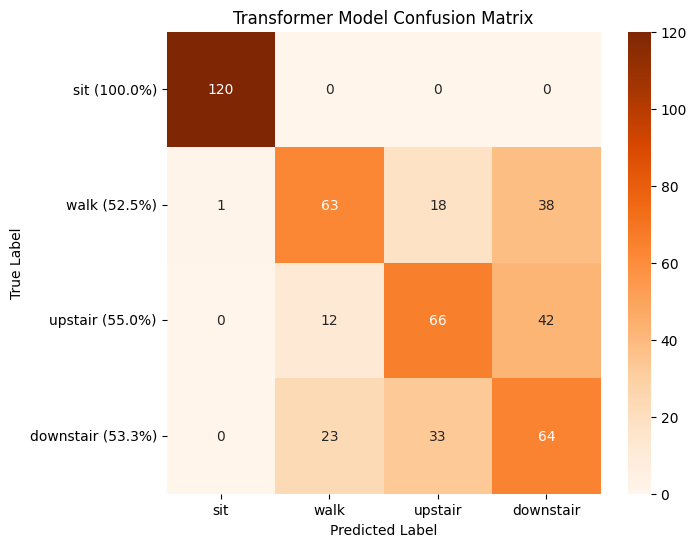

In [78]:
if __name__ == "__main__":
    train_and_evaluate()